# Data Visualization
# 1. Introduction
## Dataset Description
This Jupyter Notebook explores a dataset centered around movies, organized into three main components:
1. **The Movie Dataset**: This dataset provides detailed information about individual films. It is fragmented into multiple dataframes that are linked through a unique movie identifier key.
2. **The Oscar Awards Datasets**: This dataset contains comprehensive records of every nomination and winner since the first ceremony of the Oscars.
3. **The Rotten Tomatoes Review Dataset**: This dataset focuses on the reception of movies by critics, with data sourced from the review aggregator Rotten Tomatoes.

The Movie, the Oscar and Review datasets are not interconnected because they lack a shared unique identifier for movies. This happens because these datasets originate from entirely separate sources.<br>
Consequently, analyzing and visualizing the data presents additional challenges, as there is limited information available to effectively correlate a movie's performance and success.

## Methodology
The analysis follows a structured methodology which includes the following steps
1. **Introduction**: A brief introduction to the objective of the analysis.
2. **Prediction**: For the *In-Depth Visualization* the analysts will develop hypothesis and prediction to encourage critical thinking and expose common misconceptions.
3. **Analysis and Visualization**: Conducting *Simple* and *In-Depth* exploration of the datasets to identify patterns, trends, and relationships. Creating meaningful and creative visual representations of the data to enhance understanding and interpretation.
4. **Conclusion**: Summarizing findings and deriving insights from the analysis and visualizations and comparing them with the previous hypothesis.

## Visualization Technologies
A variety of Python libraries are employed to create both static, dynamic, interactive and geographic visualizations. The following libraries are used:
- **Plotly**: For creating interactive and dynamic plots.
- **Geopandas**: For handling and visualizing geographic data.
- **Seaborn**: For generating aesthetically pleasing statistical graphics.
- **Matplotlib**: For static visualizations.
- **Folium**: For creating interactive maps and geographic visualizations.

These tools enable a diverse range of visualization techniques, enhancing the ability to explore and interpret the data effectively.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium as fm
import plotly.express as px
import plotly.graph_objects as go

# to evaluate the use
from wordcloud import WordCloud

# 2. Exploratory Data Analysis (EDA)

### Geographic and Temporal distribution of Movie Production

Geographical and temporal distribution refers to the analysis of how data is spread across different locations (geographical) and over time (temporal). In this case, it shows how movie productions vary by country and year.
Understanding these patterns can helps identify trends, highlight regional differences, and provide information about the evolution of the global film industry over the years.

In [ ]:
# Load the datasets
movies_df = pd.read_csv('clean_datasets/movies.csv')
countries_df = pd.read_csv('clean_datasets/countries.csv')

# Merge datasets
df = pd.merge(movies_df, countries_df, left_on='id', right_on='movie_id')

# Clean the merged dataset
df = df.dropna(subset=["release_year"])
df = df.drop(columns="movie_id")
df = df.set_index("id")
df = df[df['release_year'] <= 2023]

# Group by release year and country, and count the number of movies
movie_counts = df.groupby(['release_year', 'country']).size().reset_index(name='movie_count')

After merging the datasets on *id* (from **movies_df**) and *movie_id* (from **countries_df**), the merged dataset is cleaned by removing rows with missing release years and unnecessary columns. <br>
The release_year filter ensures only movies released up to 2023 are included, as the dataset is not updated beyond that year. <br>
Finally, the data is grouped by release_year and country to count the number of movies produced each year in each country.

In [ ]:
fig = (px.choropleth(movie_counts,
                     locations='country',  # Country names in the 'country' column
                     color='movie_count',  # Number of movies per country
                     hover_name='country',
                     color_continuous_scale="Viridis",
                     title="Number of Movies Produced by Country Over Time",
                     labels={'movie_count': 'Number of Movies'},
                     locationmode="country names",  # Ensure matching by country names
                     animation_frame="release_year",  # Animate by release year
                     animation_group="country",  # Group by country during animation
                     template="plotly_dark")
       .update_layout(
           width=1000,
           height=600,
           title={'x': 0.5, 'xanchor': 'center', 'y': 0.95}
       )
       .show())

### Studio Influence on Genre

This plot is useful for understanding the dominance of specific studios within each genre. By visualizing the top 10 studios that produce the most movies in each genre, we can identify trends in studio specialization. <br>
This type of analysis helps to understand how studios influence the landscape of different film genres, offering information about industry trends and competition

In [ ]:
# Load the datasets
studios_df = pd.read_csv('clean_datasets/studios.csv')
genres_df = pd.read_csv('clean_datasets/genres.csv')

# Merge the dataset
df = pd.merge(studios_df, genres_df, left_on='movie_id', right_on='movie_id')

# Get all the genres for each studio
studio_genre_counts = df.groupby(['studio', 'genre']).size().reset_index(name='movie_count')

# Get the top 10 studios for each genre
top_studios_per_genre = (
    studio_genre_counts
    .sort_values(
        by=['genre', 'movie_count'],
        ascending=[True, False])
    .groupby('genre')
    .head(10)
)

# Add rank based on movie_count within each genre
top_studios_per_genre['rank'] = top_studios_per_genre.groupby('genre')['movie_count'].rank(method='first', ascending=False)

The dominant studio for each genre is identified by selecting the studio with the highest movie count within each genre.

In [ ]:
# Treemap
fig = px.treemap(
    top_studios_per_genre,
    path=['genre', 'studio'],
    values='movie_count',
    color='movie_count',
    color_continuous_scale='Viridis',
    title='Top 10 Dominant Studio for Each Genre'
)
fig.update_traces(textinfo='label+value', marker=dict(cornerradius=3))
fig.update_layout(
    coloraxis_colorbar=dict(title="Number of Movies"),
    height=600,
    title={'x': 0.5, 'xanchor': 'center', 'y': 0.95})
fig.show()

### Most Frequent Genres

Knowing the most frequent genres in a movie database offers valuable insights into audience preferences and trends, helping studios, distributors, and streaming platforms better understand what types of films are currently in demand.

In [ ]:
# Load dataset
genres_df = pd.read_csv('clean_datasets/genres.csv')

# Count occurrences of each genre
genre_movies = genres_df['genre'].value_counts().reset_index(name='movie_count')

In [ ]:
# Convert the DataFrame to a dictionary
genre_dict = genre_movies.set_index('genre')['movie_count'].to_dict()

# Generate the word cloud using the frequencies from the dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='kaiser')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

### Most Popular Release Type per Country

Understanding the most popular release types in different countries provides important insights into how films are distributed and consumed globally. This data visualization can help studios optimize release formats and maximize audience engagement by country.

In [ ]:
# Load the dataset
release_df = pd.read_csv('clean_datasets/releases.csv')
# Group the data by country and distribution format
country_release_counts = release_df.groupby(['country', 'distribution_format']).size().reset_index(name='movies')

# Create the dropdown menu
countries = country_release_counts['country'].unique()

In [ ]:
# Create the plot
fig = go.Figure()
# Add a trace for each country
for country in countries:
    country_data = country_release_counts[country_release_counts['country'] == country]
    fig.add_trace(go.Bar(
        x=country_data['distribution_format'],
        y=country_data['movies'],
        name=country,
        visible=False
    ))

fig.data[0].visible = True

fig.update_layout(
    title="Movie Distribution by Format per Country",
    xaxis_title="Distribution Format",
    yaxis_title="Number of Movies",
    updatemenus=[{
        'buttons': [
            {'label': country,
             'method': 'update',
             'args': [{'visible': [i == j for i in range(len(countries))]},
                      {'title': f"Movie Distribution by Format in {country}"}]}
            for j, country in enumerate(countries)
        ],
        'direction': 'down',
        'showactive': True,
        'active': list(countries).index('Italy'),
        'x': 1,
        'xanchor': 'right',
        'y': 1.1,
        'yanchor': 'bottom',
        'font': {
            'size': 14
        }
    }]
)

fig.show()

### Most Popular Release Season per Country

Representing the release window using the seasons provides valuable insights into global release patterns and helps identify the most favorable times for movie launches in different regions.

In [ ]:
from utils.utils import get_specific_season, season_colors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
release_df = pd.read_csv('clean_datasets/releases.csv')

# Preparing the data
release_df['date'] = pd.to_datetime(release_df['date'])
release_df = release_df[release_df['date'] >= '1970-01-01']
release_df['season'] = release_df['date'].apply(get_specific_season)

# Group by 'country' and 'season', and count the number of movies in each group
grouped = release_df.groupby(['country', 'season']).size().reset_index(name='movie_count')
# Best release season for each country
best_season = grouped.loc[grouped.groupby('country')['movie_count'].idxmax()]

# Map the best release season to colors
best_season['color'] = best_season['season'].map(season_colors)

# TODO: more than 200 countries I do not know how to do a readable plot

### Distribution of Countries by Release Format

Understanding the distribution of release formats by country helps identify global trends in movie distribution, highlighting which formats are most commonly adopted

In [ ]:
countries_per_format = release_df.groupby('distribution_format')['country'].nunique().reset_index(name='country counts')

plt.figure(figsize=(8, 8))
plt.pie(countries_per_format['country counts'],
        labels=countries_per_format['distribution_format'],
        autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Paired.colors)
plt.title('Proportion of Countries for Each Distribution Format')
plt.axis('equal')
plt.show()

### *Lights, Clusters, Action*: Network Graph of Actors Cultural Spheres

***Who are the most interconnected actors?***
<br> Some actors have forged extensive networks by working alongside a variety of co-stars in multiple projects.
<br> In this analysis, we will explore the relationships between actors by constructing a network graph that reveals their connections through shared films. In the graph each node will represent an actor and a shared film will form the connection between them.
<br> The network will help us identify the most central figures in the film industry, based on how many collaborations they've had, and discover clusters of actors who frequently collaborate.

***What do we expect from this analysis?***
- *Stefano*: The dataset spans far back in time, making it challenging to predict which actor or group of actors will be the most represented. However, it is likely that Hollywood stars will form one of the dominant clusters, representing a significant portion of the dataset, as observed in previous analyses.
- *Samuele*: The dataset is vast and includes not only movies but also numerous documentaries, which causes many historical figures featured in them to appear as actors. I expect clustering based on the nationality of movies and actors, with the largest cluster likely being dominated by Hollywood.

#### Analysis and Visualization

In [ ]:
# Import utils
from utils.actor_graph_network_utils import network_graph

In [ ]:
# Loading the datasets
movies_df = pd.read_csv("clean_datasets/movies.csv")
actors_df = pd.read_csv("clean_datasets/actors.csv")

In [ ]:
# Define the function that will draw the graph
def draw_network_graph(graph):
    # Centrality for a node quantifies how many connection to other node within the network (percentage).
    centrality = graph.get('centrality')

    # Draw the edge Scatter
    edge_x = graph.get('edges')[0]
    edge_y = graph.get('edges')[1]
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Draw the node scatter
    node_x = graph.get('nodes')[0]
    node_y = graph.get('nodes')[1]
    node_sizes = graph.get('nodes')[2]
    node_text = graph.get('nodes')[3]
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(
            size=node_sizes,
            color=list(centrality.values()),
            colorscale='YlGnBu',
            colorbar=dict(
                title="Node Connections"
            ),
            line=dict(width=1, color='#333')
        ),
        text=node_text,
        hoverinfo='text'
    )

    # Merge the node and edge scatter into a single plot
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=dict(
                text="<br>Network graph of top 1000 actors by connections",
                font=dict(size=16)
            ),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    )
    fig.show()

In [ ]:
# Preparing the data
## Removing unneeded columns
actors = actors_df.drop(columns=['role'])
## Taking the first 1000 most common actors to have a lighter analysis
actors = actors[actors['name'].isin(actors.value_counts(subset='name').head(1000).index)]

In [ ]:
# Build all graph info
graph = network_graph(actors)

In [ ]:
draw_network_graph(graph)

The first version of the graph shows a some clustering effect, but the separation between clusters is not very distinct.
<br> A dominant cluster contains nodes with the highest centrality, representing actors who collaborated extensively. These actors belong to an era ranging from the late 1800s to the 1970s. This could be due to a bias in the dataset, where older films and actors are more represented, maybe because of their historical significance.
<br><br>
However, the lack of clarity in the graph highlights the need for refinement. To address this, we will filter the data to include only actors from movies released after 1990. This adjustment will allow us to focus on actors more recognizable to modern audiences and provide a clearer, more relevant representation of the network.

In [ ]:
# Preparing the data
## Removing unneeded columns
actors = actors_df.drop(columns=['role'])
## Filtering actors from movies released after 1990
movies = movies_df[movies_df['release_year'] >= 1990]
actors = actors[actors['movie_id'].isin(movies['id'])]
## Taking the first 1000 most common actors to have a lighter analysis
actors = actors[actors['name'].isin(actors.value_counts(subset='name').head(1000).index)]

In [ ]:
# Build all graph info
graph = network_graph(actors)

In [ ]:
draw_network_graph(graph)

In this updated graph, the clustering effect is significantly more pronounced, and we can clearly distinguish several distinct spheres:
- **Indian Sphere**: A cluster likely representing Bollywood actors and their connections.
- **Japanese Sphere**: A smaller but noticeable group representing actors predominantly from Japanese cinema.
- **Occidental Sphere**: The largest and most dominant cluster, centered around Hollywood stars and their collaborations.
- **Minor Spheres**: Other regional groups, such as Korean, German, and French cinema, forming smaller, less connected clusters.
<br><br>
This graph marks a substantial improvement from the previous version. The separation between the clusters is much clearer, and the identification of key groups is more intuitive. Additionally, the inclusion of actors from recent movies makes it easier to recognize names and associate them with modern cinema trends.

In [ ]:
# A peek of the most interconnect actors of the modern era.
centrality = graph.get('centrality')
centrality = pd.DataFrame({'key': list(centrality.keys()), 'value': list(centrality.values())})
centrality[['key', 'value']].sort_values(by='value', ascending=False).head(15)

#### Conclusions

The analysis confirmed that the network graph forms distinct clusters primarily based on geographic and cultural spheres.
<br>As predicted, the Hollywood sphere dominates, reflecting the global influence of American cinema. Other significant clusters include the Indian sphere (Bollywood) and the Japanese sphere, both of which are more noticeable due to their unique cultural identities and relative isolation from globalization in the movie industry.
<br>By narrowing the dataset to focus on more recent movies (from the 1990s onward), the clustering effect became more pronounced, and recognizable modern actors appeared, aligning with our expectations.
<br>Older actors were initially overrepresented due to dataset bias, but filtering improved interpretability.

### *Lights and Shadows*: Poster Color Brightness Across Genres



***Does the brightness of movie posters reveal something about their genres?***
<br> Movie posters play a crucial role in setting the tone and attracting audiences, often using colors to evoke emotions that resonate with a film’s themes.
<br> In this analysis, we will examine the relationship between the brightness of movie posters and their associated genres by analyzing the average color compositions of posters. Each genre will be represented by its average Red, Green, and Blue (RGB) values, and eventually brightness will be calculated.
<br> The analysis will help us highlight how brightness and color composition might represent the different genres. A 3D scatterplot will provide an interactive visualization of these relationships.
<br><br>
***What do we expect from this analysis?***
- *Stefano & Samuele*: We expect genres like horror and thriller to exhibit darker tones, reflecting their tense and dark themes, while comedy and family movies will likely feature brighter cheerful colors. Other genres should fall somewhere in between, forming a gradient of brightness that aligns with their emotional and thematic characteristics.

#### Analysis and Visualization

**NOTE**: The posters_colors.csv dataset has been generated by the script poster_average_color.py, which processes all available posters in the dataset. The total size of the images is approximately 23 GB, making the execution of the script quite time-consuming. The file contains a commented section to perform benchmarks on portions of the dataset, and at the end of file, the timing results from a relatively fast computer are provided. It is recommended not to run the script on the entire dataset but instead to download the final result directly from the link provided in the README.

In [ ]:
# Loading the datasets
genres = pd.read_csv('clean_datasets/genres.csv')
posters_colors = pd.read_csv('clean_datasets/posters_colors.csv')

In [ ]:
# Preparing the data
## Merge the two datasets
colors_genres = genres.merge(posters_colors, left_on='movie_id', right_on='id', how="inner")
## Removing unneeded columns
colors_genres = colors_genres.drop(columns=['movie_id', 'poster_path', 'poster_link'])
## Drop the null values
colors_genres = colors_genres.dropna(subset=["average_color"])
## Split the RGB values for easier handling
colors_genres[['r', 'g', 'b']] = colors_genres['average_color'].str.split(',', expand=True).astype(int)
## Calculate brightness with relative luminance formula (source: Wikipedia)
colors_genres['brightness'] = (
        0.2126 * colors_genres['r'] +
        0.7152 * colors_genres['g'] +
        0.0722 * colors_genres['b']
).astype(int)
## Group by genre to see average brightness
colors_genres = colors_genres.groupby('genre')[['r', 'g', 'b', 'brightness']].mean().reset_index()

In [ ]:
# Create 3D scatterplot
fig = px.scatter_3d(
    colors_genres,
    x='r', y='g', z='b',
    color='brightness',  # Use brightness as the color scale
    text='genre',
    title='Genres Based on Average Brightness',
    color_continuous_scale='Greys_r'  # Use a grayscale color map
)
fig.update_layout(
    scene=dict(
        xaxis_title='Red (R)',
        yaxis_title='Green (G)',
        zaxis_title='Blue (B)',
        camera=dict(
            up=dict(x=0, y=0, z=2),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=2, y=-1.5, z=0.5)
        )
    ),
    width=1200,
    height=600,
    title={'x': 0.5, 'xanchor': 'center', 'y': 0.95})
fig.show()

#### Conclusions

The analysis confirmed that the relationship between movie poster brightness and genres aligns with expected trends, forming clear distinctions in color usage based on thematic tones.
<br>
As predicted, darker genres like Horror, Thriller, and Mystery tend to have lower brightness levels, reflecting their association with suspense and fear. In contrast, lighter genres like Comedy, Family, and Animation exhibit higher brightness values, conveying a more cheerful and playful mood.
Interestingly, genres such as Drama and Science Fiction occupy intermediate positions, showcasing a mix of brightness levels that likely represent their diverse thematic elements.
<br>
This trend underscores the role of color psychology in shaping audience perceptions and highlights how genre conventions are reflected even in visual materials like movie posters.

### Correlation between movie genre and theme (TODO)

In [ ]:
movie_df = pd.read_csv('clean_datasets/movies.csv')
genre_df = pd.read_csv('clean_datasets/genres.csv')
theme_df = pd.read_csv('clean_datasets/themes.csv')

In [ ]:
theme_df.value_counts(subset='theme')

In [ ]:
genre_theme_df = pd.merge(genre_df[['movie_id', 'genre']], theme_df[['movie_id', 'theme']], on='movie_id')
top_combinations = genre_theme_df.groupby(['genre', 'theme']).size().reset_index(name='count')

# Create an interactive bubble plot using Plotly
fig = px.scatter(top_combinations,
                 x='genre',
                 y='theme',
                 size='count',
                 color='count',
                 hover_name='theme',
                 hover_data={'genre': True, 'count': True},
#                 color_continuous_scale='',
                 title='Bubble Plot of Genre-Theme Combinations with Hovering')

# Adjust layout for better readability
fig.update_layout(
    height=1200,  # Ensure enough height for themes
    xaxis_title="Genre",
    yaxis_title="Theme",
    xaxis_tickangle=45,
    yaxis_tickangle=0,
)

# Show the plot
fig.show()

### Distribution types barchart (TODO)

In [33]:
# Load the dataset
releases_df = pd.read_csv('clean_datasets/releases.csv')
movies_df = pd.read_csv('clean_datasets/movies.csv')

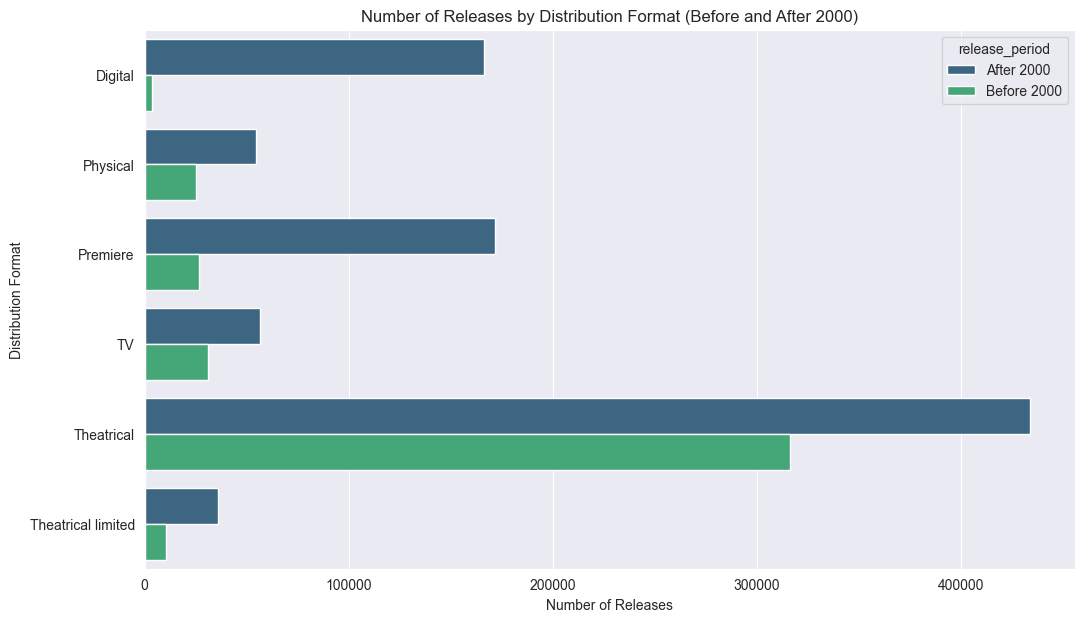

In [38]:
# Merge the two datasets on the movie_id (releases) and id (movies)
merged_df = pd.merge(releases_df, movies_df, left_on='movie_id', right_on='id')

# Create a new column to categorize movies as before or after 2000
merged_df['release_period'] = merged_df['release_year'].apply(lambda x: 'Before 2000' if x < 2000 else 'After 2000')

# Count the occurrences of each distribution format, split by release period
distribution_counts = merged_df.groupby(['distribution_format', 'release_period']).size().reset_index(name='Count')

# Set the size of the plot
plt.figure(figsize=(12, 7))

# Create the bar plot using Seaborn
sns.barplot(x='Count', y='distribution_format', hue='release_period', data=distribution_counts, palette='viridis')

# Set labels and title
plt.xlabel('Number of Releases')
plt.ylabel('Distribution Format')
plt.title('Number of Releases by Distribution Format (Before and After 2000)')

# Display the plot
plt.show()

### (TODO)